In [3]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
import os

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",google_api_key=os.getenv("GEMINI_API_KEYY") )


In [6]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, SystemMessage
# from langchain_core.utils.function_calling import add_messages
from operator import add as add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]



def app_stream(content):
    print("🌀 State:", content)


@tool
def run_phq9_assessment() -> dict:
    """Run PHQ-9 depression screening assessment FOR user if it is needed"""
    print("🔧 Running PHQ-9 Assessment")
    questions = [
        "Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?",
        "How often have you felt down, depressed, or hopeless?",
        "How often have you had trouble falling or staying asleep?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "PHQ9", "score": score}


@tool
def run_gad7_assessment() -> dict:
    """Run GAD-7 anxiety screening assessment FOR user if it is needed"""

   

    print("🔧 Running GAD-7 Assessment")
    questions = [
        "Have you been feeling nervous or on edge?",
        "Do you find it difficult to stop worrying?",
        "Do you feel easily irritated?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "GAD7", "score": score}


tools = [run_phq9_assessment, run_gad7_assessment]

llm_with_tools = llm.bind_tools(tools)



def emotional_check_in_node(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content="You are a compassionate emotional helper  assistant. Note that If the user needs further help, call an appropriate assessment tool[run_phq9_assessment or run_gad7_assessment]." #Do not call the tool at the start , call only the if you feel that user need to be assessed with tools  "
    )
    response = llm_with_tools.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}



def should_continue(state: AgentState) -> str:
    last = state["messages"][-1]
    if not getattr(last, "tool_calls", None):
        return "end"
    return "continue"



builder = StateGraph(AgentState)

# Tool Node
tool_node = ToolNode(tools=tools)
builder.add_node("PHQ9/GAD-7 TOOLS", tool_node)

builder.add_node("emotional_check_in_node", emotional_check_in_node)

builder.add_edge("PHQ9/GAD-7 TOOLS", "emotional_check_in_node")
builder.add_conditional_edges(
    "emotional_check_in_node",
    should_continue,
    {
        "continue": "PHQ9/GAD-7 TOOLS",
        "end": END,
    }
)

builder.set_entry_point("emotional_check_in_node")



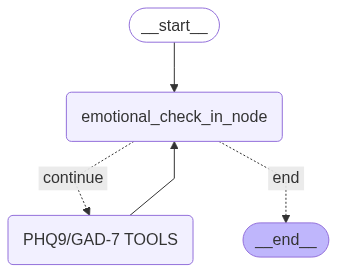

In [7]:
builder.compile()


In [8]:
graph = builder.compile()


In [9]:



initial_state: AgentState = {
    "messages": [("user", "Hi run phq9 test for me now pleae")]
}

for step in graph.stream(initial_state):
    app_stream(step)

🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'run_phq9_assessment', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--7346921e-df40-4b81-ad1c-d0d76d29134d-0', tool_calls=[{'name': 'run_phq9_assessment', 'args': {}, 'id': 'e5724d93-a9cb-4807-a484-146c57681cc6', 'type': 'tool_call'}])]}}
🔧 Running PHQ-9 Assessment
🤖: Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?
🤖: How often have you felt down, depressed, or hopeless?
🤖: How often have you had trouble falling or staying asleep?
🌀 State: {'PHQ9/GAD-7 TOOLS': {'messages': [ToolMessage(content='{"tool_name": "PHQ9", "score": 9}', name='run_phq9_assessment', tool_call_id='e5724d93-a9cb-4807-a484-146c57681cc6')]}}
🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(conten

In [10]:



initial_state: AgentState = {
    "messages": [("user", "Hi run GAD-7 test for me now pleae")]
}

for step in graph.stream(initial_state):
    app_stream(step)

🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'run_gad7_assessment', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--47e621e4-cd34-4dce-8f73-01863b562038-0', tool_calls=[{'name': 'run_gad7_assessment', 'args': {}, 'id': '6818447f-6ae8-496e-9acd-4413e268d4d6', 'type': 'tool_call'}])]}}
🔧 Running GAD-7 Assessment
🤖: Have you been feeling nervous or on edge?
🤖: Do you find it difficult to stop worrying?
🤖: Do you feel easily irritated?
🌀 State: {'PHQ9/GAD-7 TOOLS': {'messages': [ToolMessage(content='{"tool_name": "GAD7", "score": 9}', name='run_gad7_assessment', tool_call_id='6818447f-6ae8-496e-9acd-4413e268d4d6')]}}
🌀 State: {'emotional_check_in_node': {'messages': [AIMessage(content='Okay, I have run the GAD-7 assessment for you. The result indicates a score of 9.', ad

In [1]:
from langgraph.graph import StateGraph, END,add_messages
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from typing import List, Dict, Any, TypedDict, Annotated, Sequence,List, Union
from typing import TypedDict, List, Optional
from langchain_core.messages import AIMessage, HumanMessage


class AgentState(TypedDict, total=False):
    tool_name: str                         # e.g., "PHQ9"
    next_question: str                     # Current PHQ9 question to ask
    phq9_answers: List[str]                # List of user responses
    completed: bool                        # True when PHQ9 is done
    score: int                             # Final PHQ9 score
    tool_calls: List[str]                  # Tool names to invoke
    #messages: List[AIMessage | HumanMessage]  # Message history
    
    messages: Annotated[Sequence[BaseMessage], add_messages]
    latest_user_input: str                 # Most recent user reply

def screening_node(state:AgentState) -> AgentState:

    print(".........................1")
    # This node just triggers the PHQ-9 Tool
    return { "tool_calls": ["run_phq9_step"]}


@tool
def run_phq9_step(state: AgentState) -> AgentState:
    """this runs phq9 test"""
    print(".........................2")



    
    questions = [
        "Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?",
        "How often have you felt down, depressed, or hopeless?",
        "How often have you had trouble falling or staying asleep?"
    ]

    answers = state.get("phq9_answers", [])
    index = len(answers)

    state['next_question'] = questions[index]
    print(questions[index])

    if index < len(questions):
        return {
            "tool_name": "PHQ9",
            "next_question": questions[index],
            "phq9_answers": answers,
            "completed": False
        }
    else:
        score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
        return {
            "tool_name": "PHQ9",
            "score": score,
            "completed": True
        }






def question_node(state:AgentState)->AgentState:
    # Ask the current question
    question = state.get("next_question")
    print("question =  ")
    print( question)
   


def answer_capture_node(state:AgentState)->AgentState:
    # Simulate capturing a response
    user_input = state.get("latest_user_input", "Yes")  # Replace with actual user input capture
    print("user =  ")
    print( user_input)
    answers = state.get("phq9_answers", [])
    return {**state, "phq9_answers": answers + [user_input]}


def review_node(state:AgentState)->AgentState:
    score = state.get("score")
    print("score = ")
    print( score)
  


def should_continue(state: AgentState) -> str:
   if state["completed"] == True:
      
      return "review"
   else:
      return "ask_question"
   


graph = StateGraph(AgentState)

# Entry point: screening triggers tool
graph.add_node("screening", screening_node)

# ToolNode: PHQ9 step tool
graph.add_node("phq9_tool", ToolNode(tools=[run_phq9_step]))

# Ask question and get response
graph.add_node("ask_question", question_node)
graph.add_node("capture_answer", answer_capture_node)

# Show final score
graph.add_node("review", review_node)




graph.set_entry_point("screening")
graph.add_edge("screening", "phq9_tool")
graph.add_conditional_edges(

    "phq9_tool",
    should_continue,
   {
        "review": "review",
        "ask_question": "ask_question",

   }
)


graph.add_edge("ask_question", "capture_answer")
graph.add_edge("capture_answer", "phq9_tool")

app = graph.compile()


initial_state = {
    "phq9_answers": [],
    "messages": [AIMessage(content="Starting PHQ-9 assessment...")],
    "completed": False,
    "tool_calls": [],
}

result =app.invoke(initial_state)

print(result)

.........................1
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes
question =  
None
user =  
Yes


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

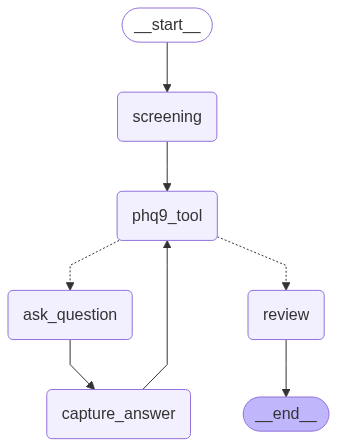

In [2]:
graph.compile()